<a href="https://colab.research.google.com/github/PavelStelmakhV/hw310-keras-fasion-mnist/blob/main/keras_fasion_mnist_hw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [426]:
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt
from keras import layers
from keras import regularizers

In [427]:
fashion_mnist = tf.keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

In [428]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [429]:
train_images = train_images / 255.0

test_images = test_images / 255.0

In [430]:
model = tf.keras.Sequential()

model.add(layers.Flatten(input_shape=(28, 28)))
# model.add(layers.Dropout(0.5))
model.add(layers.Dense(1000, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(1000, activation='relu'))
# model.add(layers.Dense(80, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.Dropout(0.3))
# model.add(layers.Dense(40, activation='relu', kernel_regularizer=regularizers.l2(0.001)))

model.add(layers.Dense(10))
# model.add(layers.Softmax())

In [431]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [432]:
# model.fit(train_images, train_labels, epochs=20)
history = model.fit(train_images,
                    train_labels,
                    epochs=20,
                    batch_size=64,
                    validation_data=(test_images, test_labels))
test_loss, test_acc = model.evaluate(test_images, test_labels)
print('\nTest accuracy:', test_acc)

Epoch 1/20
938/938 [==============================] - 32s 33ms/step - loss: 0.5160 - accuracy: 0.8118 - val_loss: 0.4133 - val_accuracy: 0.8490
Epoch 2/20
938/938 [==============================] - 31s 33ms/step - loss: 0.4059 - accuracy: 0.8508 - val_loss: 0.4213 - val_accuracy: 0.8410
Epoch 3/20
938/938 [==============================] - 32s 34ms/step - loss: 0.3711 - accuracy: 0.8632 - val_loss: 0.3853 - val_accuracy: 0.8622
Epoch 4/20
938/938 [==============================] - 31s 33ms/step - loss: 0.3519 - accuracy: 0.8713 - val_loss: 0.3565 - val_accuracy: 0.8704
Epoch 5/20
938/938 [==============================] - 33s 35ms/step - loss: 0.3413 - accuracy: 0.8743 - val_loss: 0.3500 - val_accuracy: 0.8724
Epoch 6/20
938/938 [==============================] - 31s 33ms/step - loss: 0.3264 - accuracy: 0.8779 - val_loss: 0.3374 - val_accuracy: 0.8773
Epoch 7/20
938/938 [==============================] - 33s 35ms/step - loss: 0.3156 - accuracy: 0.8829 - val_loss: 0.3406 - val_accuracy:

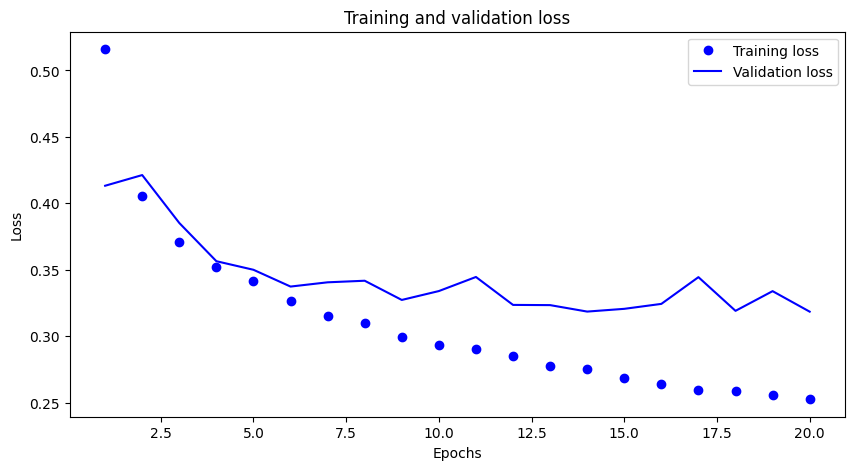

<Figure size 640x480 with 0 Axes>

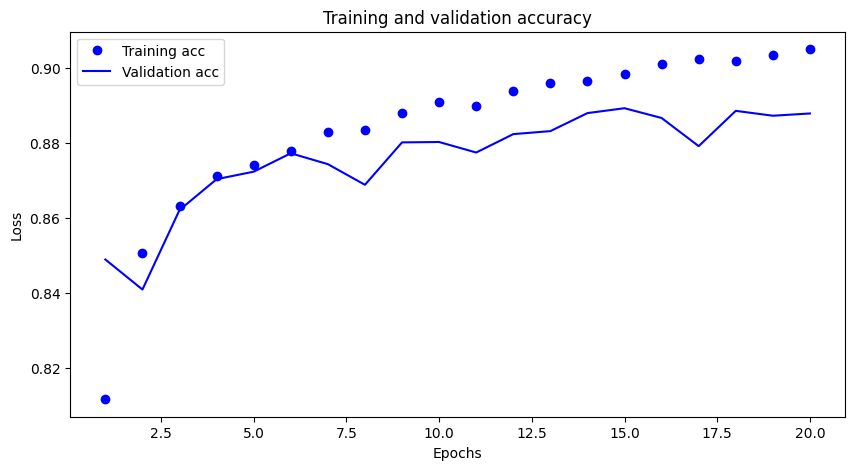

In [433]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(history_dict['accuracy']) + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.clf()
plt.figure(figsize=(10, 5))
val_acc_values = history_dict['val_accuracy']
plt.plot(epochs, history_dict['accuracy'], 'bo', label='Training acc')
plt.plot(epochs, history_dict['val_accuracy'], 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [434]:
probability_model = tf.keras.Sequential([model,
                                         tf.keras.layers.Softmax()])

In [435]:
predictions = probability_model.predict(test_images)

313/313 [==============================] - 2s 6ms/step


In [436]:
predictions[0]

array([7.6195605e-11, 1.5865330e-10, 1.8582515e-10, 2.7242672e-12,
       2.6813100e-12, 1.2204280e-05, 1.3034785e-11, 5.3238310e-04,
       2.2733752e-10, 9.9945533e-01], dtype=float32)